# Import Packages and Load Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pm
import joblib

import warnings
warnings.filterwarnings("ignore")

sns.set_style('ticks', rc={"xtick.direction": "in", "ytick.direction": "in"})
%matplotlib inline

In [2]:
''' data directories '''

datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'

In [3]:
candy = pd.read_csv(os.path.join(datadir,'candy_production.csv'), index_col='date', parse_dates=True)
earthquake = pd.read_csv(os.path.join(datadir,'earthquakes.csv'), index_col='date', parse_dates=True)
earthquake.drop(columns=['Year'], inplace=True)
amazon = pd.read_csv(os.path.join(datadir,'amazon_close.csv'), index_col='date', parse_dates=True)
milk_production = pd.read_csv(os.path.join(datadir,'milk_production.csv'), index_col='date', parse_dates=True)

In [4]:
city = pd.read_csv(os.path.join(datadir_pr,'city_pop.csv'), index_col='date', parse_dates=True)
sample = pd.read_csv(os.path.join(datadir_pr,'sample_timeseries.csv'), index_col=0)
hospital = pd.read_csv(os.path.join(datadir_pr,'hospital_wait.csv'), index_col=0, parse_dates=True)
df_acf = pd.read_csv(os.path.join(datadir_pr,'sample_acf.csv'), index_col=0, parse_dates=True)
savings = pd.read_csv(os.path.join(datadir_pr,'savings.csv'), index_col='date', parse_dates=True)
water = pd.read_csv(os.path.join(datadir_pr,'water_london.csv'), index_col='date', parse_dates=True)
sample_sarima = pd.read_csv(os.path.join(datadir_pr,'sample_sarima.csv'), index_col=0, parse_dates=True)
aus_employment = pd.read_csv(os.path.join(datadir_pr,'australia_employ.csv'), index_col='date', parse_dates=True)
wisconsin_test = pd.read_csv(os.path.join(datadir_pr,'wisconsin_test.csv'), index_col='date', parse_dates=True)

In [5]:
aus_employment.head()

,people_employed
date,
1978-01-01,5985.7
1978-02-01,6040.6
1978-03-01,6054.2
1978-04-01,6038.3
1978-05-01,6031.3


In [6]:
sample_sarima.head()

,Y
2013-01-01,-259.864025
2013-01-02,695.803849
2013-01-03,25.506578
2013-01-04,-474.447067
2013-01-05,450.390057


In [7]:
water.head()

,water_consumers
date,
1983-01-01,24963
1983-02-01,27380
1983-03-01,32588
1983-04-01,25511
1983-05-01,32313


In [8]:
milk_production.head()

,pounds_per_cow
date,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [9]:
df_acf.head()

,y
2013-01-01,1.624345
2013-01-02,-0.936625
2013-01-03,0.081483
2013-01-04,-0.663558
2013-01-05,0.738023


In [10]:
hospital.head()

,wait_times_hrs,nurse_count
2019-03-04 00:00:00,1.747261,1.0
2019-03-04 01:00:00,1.664634,1.0
2019-03-04 02:00:00,1.647047,1.0
2019-03-04 03:00:00,1.619512,1.0
2019-03-04 04:00:00,1.480415,1.0


In [11]:
sample.head()

,timeseries_1,timeseries_2
0,-0.183108,-0.183108
1,-0.245540,-0.117365
2,-0.258830,-0.218789
3,-0.279635,-0.169041
4,-0.384736,-0.282374


In [12]:
amazon.head()

,close
date,
2019-02-08,1588.22
2019-02-07,1614.37
2019-02-06,1640.26
2019-02-05,1658.81
2019-02-04,1633.31


In [13]:
earthquake.head()

,earthquakes_per_year
date,
1900-01-01,13.0
1901-01-01,14.0
1902-01-01,8.0
1903-01-01,10.0
1904-01-01,16.0


In [14]:
candy.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [15]:
candy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1972-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IPG3113N  564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


# Chap1. ARIMA Models

## explore time series data

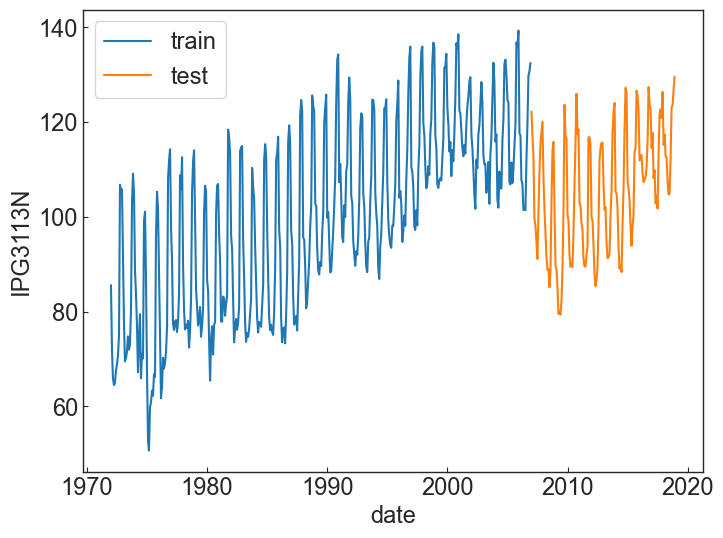

In [16]:
# Split the data into a train and test set
candy_train = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
sns.lineplot(x=candy_train.index, y=candy_train.IPG3113N, label='train', ax=ax)
sns.lineplot(x=candy_test.index, y=candy_test.IPG3113N, label='test', ax=ax);

## Augmented Dicky-Fuller Test (stationary test)

In [17]:
# Run test
result = adfuller(earthquake.earthquakes_per_year)
print('test statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('critical values: {}'.format(result[4]))

test statistics: -3.1831922511917816
p-value: 0.020978425256003668
critical values: {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


> - test statistics: more negative -> more likely to be stationary
> - p-value: smaller -> more likely to reject null hypothesis (non-stationary) -> more stationary

## Making stationary: Differencing

ADF Statistic: 5.297698878151181
p-value: 1.0


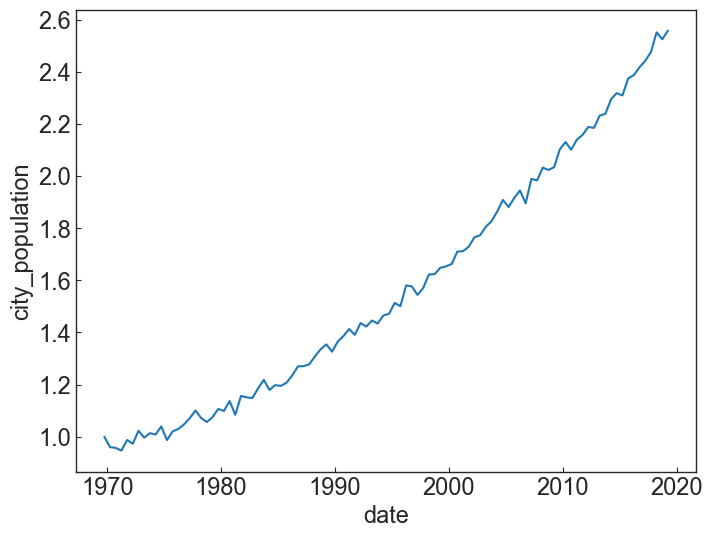

In [18]:
# Run the ADF test on the time series
result = adfuller(city.city_population)

# Plot the time series
sns.lineplot(x=city.index, y=city.city_population);

# Print the test statistic and the p-value
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

ADF Statistic: -0.8146211646182199
p-value: 0.8147894381484755


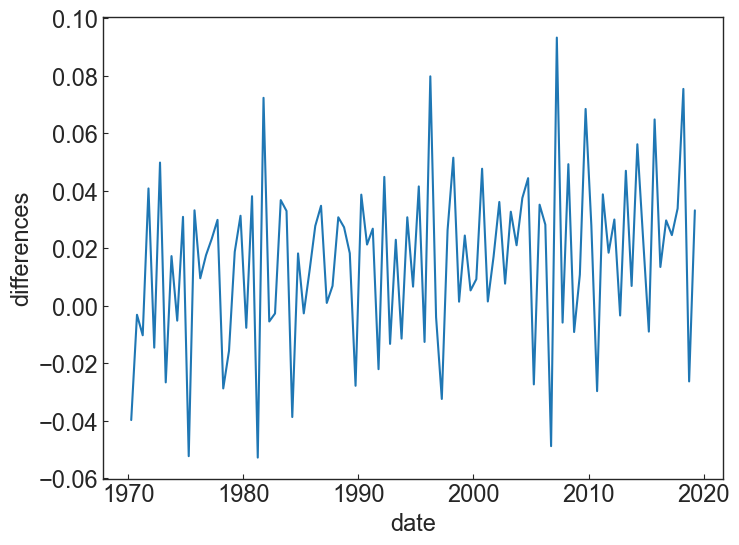

In [19]:
# Calculate the first difference of the time series
city_stationary = city.diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(city_stationary.city_population)

# Plot the differenced time series
fig, ax = plt.subplots()
sns.lineplot(x=city_stationary.index, y=city_stationary.city_population, ax=ax)
ax.set_ylabel('differences')

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.433646032918714
p-value: 1.6734498510402883e-08


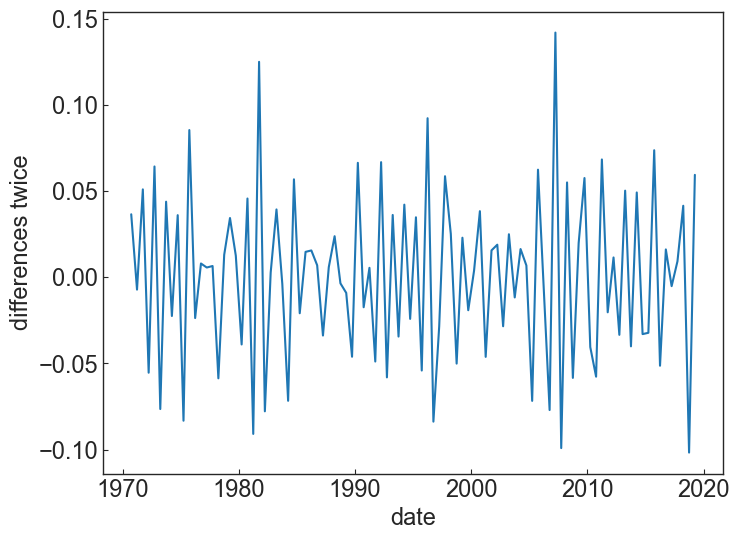

In [20]:
# Calculate the second difference of the time series
city_stationary = city.diff().diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(city_stationary.city_population)

# Plot the differenced time series
fig, ax = plt.subplots()
sns.lineplot(x=city_stationary.index, y=city_stationary.city_population, ax=ax)
ax.set_ylabel('differences twice')

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## Other transform (e.g., log)

In [21]:
# Calculate the first difference and drop the nans
amazon_diff = amazon.diff()
amazon_diff = amazon_diff.dropna()

# Run test and print
result_diff = adfuller(amazon_diff['close'])

# Print the test statistic and the p-value
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

# Calculate log-return and drop nans
amazon_log = np.log(amazon)
amazon_log = amazon_log.dropna()

# Run test and print
result_log = adfuller(amazon_log['close'])
# Print the test statistic and the p-value
print('='*10+' log transform '+'='*10)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic: -7.2035794888112425
p-value: 2.331271725487213e-10
========== log transform ==========
ADF Statistic: -7.2035794888112425
p-value: 2.331271725487213e-10


# Chap2. Fitting the Future

## AR/MA Models

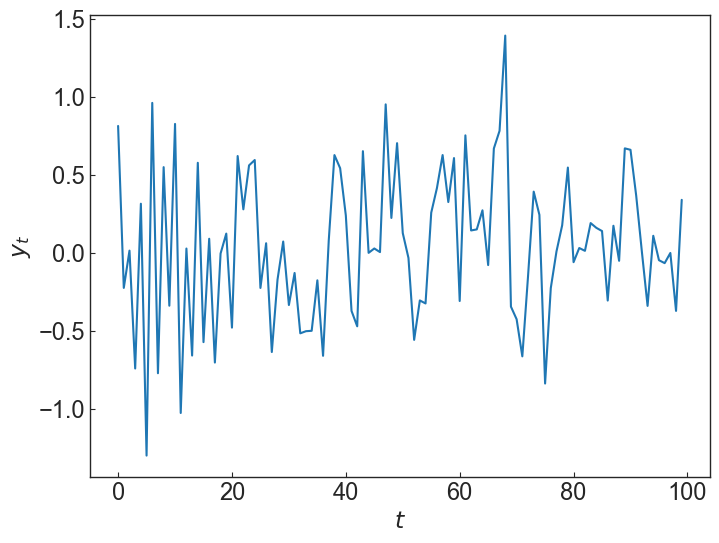

In [22]:
''' generate 100 days worth of AR/MA/ARMA '''

np.random.seed(1)

# Set coefficients
ar_coefs = [1,0.2]
ma_coefs = [1,0.3,0.4]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

fig, ax = plt.subplots()
ax.plot(y)
ax.set_ylabel(r'$y_t$')
ax.set_xlabel(r'$t$');

<div class="alert alert-warning">
    - The list ar_coefs has the form [1, -a_1, -a_2, ..., -a_p] </br>
    - The list ma_coefs has the form [1, m_1, m_2, ..., m_q] </br>
</div>

In [23]:
# Instantiate the model
model = ARIMA(sample['timeseries_1'], order=(2,0,0))  # AR(2) Model

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           timeseries_1   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 148.855
Date:                Sun, 25 Sep 2022   AIC                           -289.709
Time:                        03:01:45   BIC                           -270.078
Sample:                             0   HQIC                          -282.248
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.018     -0.151      0.880      -0.037       0.032
ar.L1          0.8980      0.031     28.660      0.000       0.837       0.959
ar.L2         -0.2704      0.032     -8.561      0.0

In [24]:
# Instantiate the model
model = ARIMA(sample['timeseries_2'], order=(0,0,3))    # MA(3) Model

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           timeseries_2   No. Observations:                 1000
Model:                 ARIMA(0, 0, 3)   Log Likelihood                 149.007
Date:                Sun, 25 Sep 2022   AIC                           -288.014
Time:                        03:01:45   BIC                           -263.475
Sample:                             0   HQIC                          -278.687
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.012     -0.158      0.875      -0.025       0.021
ma.L1          0.1995      0.032      6.183      0.000       0.136       0.263
ma.L2          0.6359      0.025     25.435      0.0

In [25]:
# Instantiate the model
model = ARIMA(earthquake, order=(3,0,1))

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                   ARIMA(3, 0, 1)   Log Likelihood                -315.673
Date:                  Sun, 25 Sep 2022   AIC                            643.345
Time:                          03:01:45   BIC                            658.916
Sample:                      01-01-1900   HQIC                           649.645
                           - 01-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6453      2.233      8.798      0.000      15.269      24.022
ar.L1          0.5795      0.645      0.899      0.369      -0.684       1.843
ar.L2          0.0251      0.308    

## Fitting to ARMAX Models 
- correlated to exogenous variable

In [26]:
# Instantiate the model
model = ARIMA(hospital["wait_times_hrs"], order=(2,0,1), exog=hospital["nurse_count"])

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:         wait_times_hrs   No. Observations:                  168
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -11.834
Date:                Sun, 25 Sep 2022   AIC                             35.668
Time:                        03:01:45   BIC                             54.411
Sample:                    03-04-2019   HQIC                            43.275
                         - 03-10-2019                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1001      0.086     24.375      0.000       1.931       2.269
nurse_count    -0.1171      0.012     -9.562      0.000      -0.141      -0.093
ar.L1           0.5693      0.169      3.365    

## Forecasting

### One-stop-ahead Predictions

In [27]:
amazon.sort_index(ascending=True, inplace=True)

# Instantiate the model
model = ARIMA(amazon.close, order=(3,1,3), seasonal_order=(1,0,1,7))

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                 1259
Model:             ARIMA(3, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -5529.097
Date:                           Sun, 25 Sep 2022   AIC                          11076.194
Time:                                   03:01:47   BIC                          11122.430
Sample:                                        0   HQIC                         11093.570
                                          - 1259                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0809      0.016     -4.995      0.000      -0.113      -0.049
ar.L2         -0.1601      0.015    -10.495

In [28]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate  predictions
print(mean_forecast)

date
2018-12-27    1478.777826
2018-12-28    1467.254224
2018-12-31    1471.663453
2019-01-02    1494.183596
2019-01-03    1535.525185
2019-01-04    1507.496120
2019-01-07    1584.079657
2019-01-08    1630.067870
2019-01-09    1649.356130
2019-01-10    1650.881803
2019-01-11    1657.838371
2019-01-14    1648.484098
2019-01-15    1626.414164
2019-01-16    1671.686005
2019-01-17    1674.133984
2019-01-18    1687.954842
2019-01-22    1700.309797
2019-01-23    1640.992901
2019-01-24    1646.047828
2019-01-25    1650.685781
2019-01-28    1660.585802
2019-01-29    1633.507508
2019-01-30    1602.299356
2019-01-31    1681.697713
2019-02-01    1718.984157
2019-02-04    1614.395822
2019-02-05    1629.058431
2019-02-06    1658.689616
2019-02-07    1651.769610
2019-02-08    1620.280764
Name: predicted_mean, dtype: float64


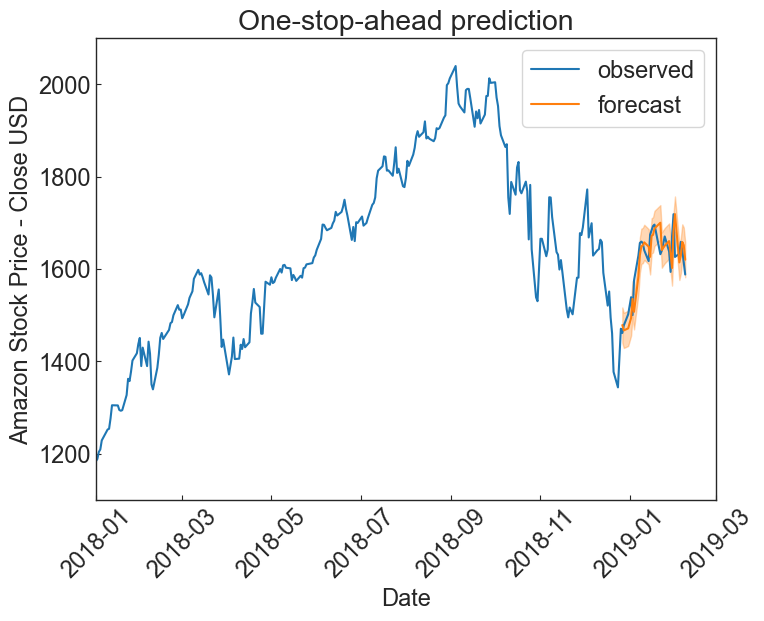

In [29]:
''' plotting the forecast '''

fig, ax = plt.subplots()

sns.lineplot(x=amazon.index, y=amazon.close, label='observed', ax=ax)

# plot your mean predictions
sns.lineplot(x=mean_forecast.index, y=mean_forecast, color='C1', label='forecast', ax=ax)

# shade the area between your confidence limits
ax.fill_between(mean_forecast.index, lower_limits, upper_limits, color='C1', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Amazon Stock Price - Close USD')
ax.set_title('One-stop-ahead prediction')
ax.set_xlim(datetime.date(2018, 1, 1),datetime.date(2019, 3, 1))
ax.set_ylim(1100,2100)
ax.tick_params(axis='x', rotation=45)

### Dynamic forecast

In [30]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-30, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate predictions
print(mean_forecast)

date
2018-12-27    1478.777826
2018-12-28    1484.673974
2018-12-31    1477.548238
2019-01-02    1469.806718
2019-01-03    1466.214247
2019-01-04    1475.929223
2019-01-07    1481.641804
2019-01-08    1483.967577
2019-01-09    1475.057232
2019-01-10    1469.332776
2019-01-11    1469.134571
2019-01-14    1478.805508
2019-01-15    1484.880518
2019-01-16    1481.604438
2019-01-17    1472.591375
2019-01-18    1469.479372
2019-01-22    1473.673738
2019-01-23    1482.542140
2019-01-24    1484.364264
2019-01-25    1480.151309
2019-01-28    1470.353649
2019-01-29    1470.975398
2019-01-30    1477.902207
2019-01-31    1485.963990
2019-02-01    1483.733143
2019-02-04    1476.268144
2019-02-05    1470.876713
2019-02-06    1473.257446
2019-02-07    1481.912663
2019-02-08    1487.337596
Name: predicted_mean, dtype: float64


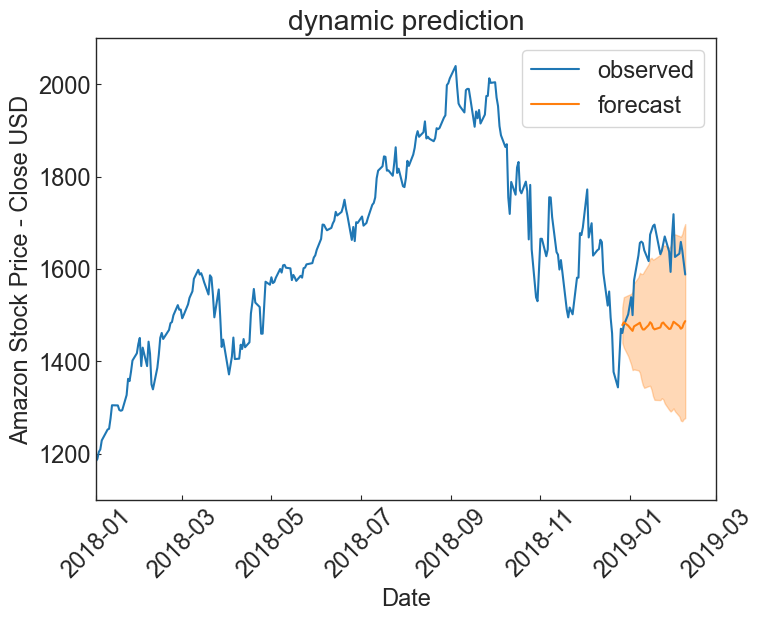

In [31]:
''' plotting the forecast '''

fig, ax = plt.subplots()

sns.lineplot(x=amazon.index, y=amazon.close, label='observed', ax=ax)

# plot your mean predictions
sns.lineplot(x=mean_forecast.index, y=mean_forecast, color='C1', label='forecast', ax=ax)

# shade the area between your confidence limits
ax.fill_between(mean_forecast.index, lower_limits, upper_limits, color='C1', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Amazon Stock Price - Close USD')
ax.set_title('dynamic prediction')
ax.set_xlim(datetime.date(2018, 1, 1),datetime.date(2019, 3, 1))
ax.set_ylim(1100,2100)
ax.tick_params(axis='x', rotation=45)

## ARIMA Model -- Differencing and fitting

In [32]:
# Take the first difference of the data
amazon_diff = amazon.diff().dropna()

# Create ARMA(2,2) model
arma = ARIMA(amazon_diff, order=(2,0,2))

# Fit model
arma_results = arma.fit()

# Print fit summary
print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1258
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5532.371
Date:                Sun, 25 Sep 2022   AIC                          11076.743
Time:                        03:01:49   BIC                          11107.566
Sample:                             0   HQIC                         11088.327
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9870      0.494      1.997      0.046       0.018       1.956
ar.L1         -0.1542      0.073     -2.120      0.034      -0.297      -0.012
ar.L2          0.7944      0.072     11.084      0.0

In [33]:
# Make arma forecast of next 10 differences
arma_diff_forecast = arma_results.get_forecast(steps=10).predicted_mean

# Integrate the difference forecast
arma_int_forecast = np.cumsum(arma_diff_forecast)

# Make absolute value forecast
arma_value_forecast = arma_int_forecast + amazon.iloc[-1,0]

# Print forecast
print(arma_value_forecast)

1258    1592.061981
1259    1594.211438
1260    1597.287277
1261    1598.875722
1262    1601.429415
1263    1602.652680
1264    1604.847869
1265    1605.836297
1266    1607.782888
1267    1608.623084
Name: predicted_mean, dtype: float64


In [34]:
''' the same process with the one above, but using differencing in ARIMA model '''

# Create ARIMA(2,1,2) model  -> d=1
arima = ARIMA(amazon, order=(2,1,2))  

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

1259    1593.620977
1260    1601.904160
1261    1605.452173
1262    1601.031355
1263    1592.738587
1264    1588.204878
1265    1591.573447
1266    1599.713618
1267    1605.130060
1268    1602.864217
Name: predicted_mean, dtype: float64


# Chap3. The Best of the Best Models

## Autocorrelation Function (ACF) and Paritial Autocorrelation Function (PACF)

| | AR(p) | MA(q) | ARMA(p,q) |
| ---  | --- | --- | --- |
| ACF  | Tails off | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p | Tails off | Tails off |

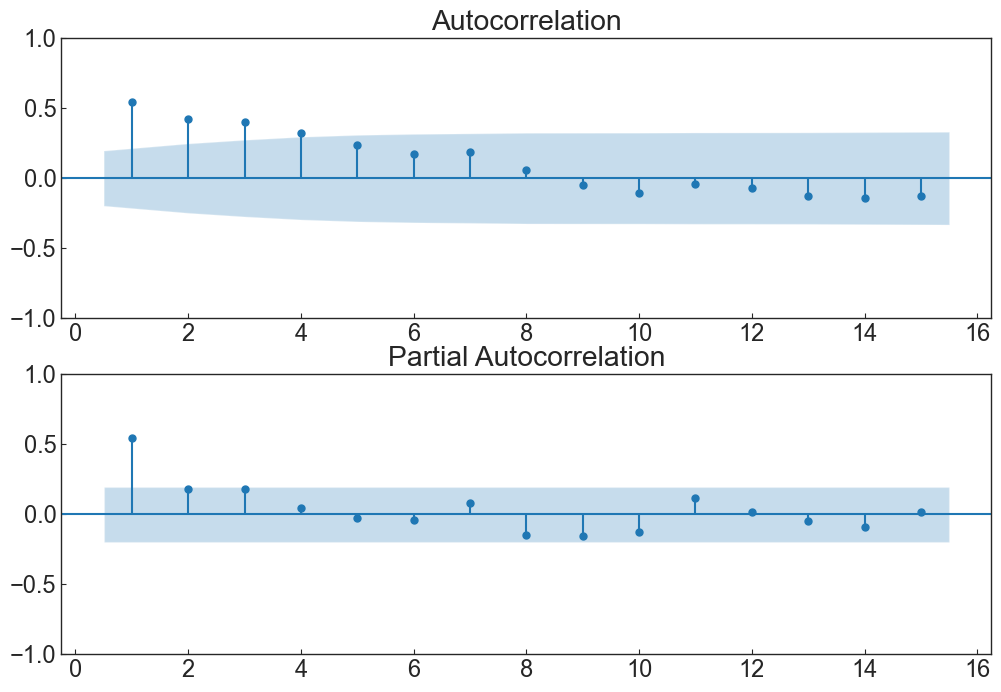

In [35]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF and PACF
plot_acf(earthquake, lags=15, zero=False, ax=ax1)
plot_pacf(earthquake, lags=15, zero=False, ax=ax2);

> AR(1) is appropriate for this dataset

## AIC and BIC values to check the performance

In [36]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = ARIMA(earthquake, order=(p,0,q))
            results = model.fit()
            
            # Print order and results
            #print(p, q, results.aic, results.bic)
            order_aic_bic.append((p,q,results.aic, results.bic))
            
        except:
            print("No good: ", p, q, None, None)

In [37]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print("----- sort by AIC -----")
print(order_df.sort_values('AIC'))

print("----- sort by BIC -----")
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

----- sort by AIC -----
   p  q         AIC         BIC
4  1  1  640.456284  650.836763
5  1  2  642.380867  655.356467
8  2  2  642.468590  658.039309
6  2  0  642.733854  653.114333
3  1  0  643.967677  651.753037
7  2  1  647.440664  660.416263
2  0  2  651.733227  662.113706
1  0  1  654.846859  662.632218
0  0  0  676.544359  681.734599
----- sort by BIC -----
   p  q         AIC         BIC
4  1  1  640.456284  650.836763
3  1  0  643.967677  651.753037
6  2  0  642.733854  653.114333
5  1  2  642.380867  655.356467
8  2  2  642.468590  658.039309
7  2  1  647.440664  660.416263
2  0  2  651.733227  662.113706
1  0  1  654.846859  662.632218
0  0  0  676.544359  681.734599


## Model diagnostics
- The mean absolute error (MAE) is a good statistic for checking how accurate the model is

Mean Absolute Error: 4.568988294818173


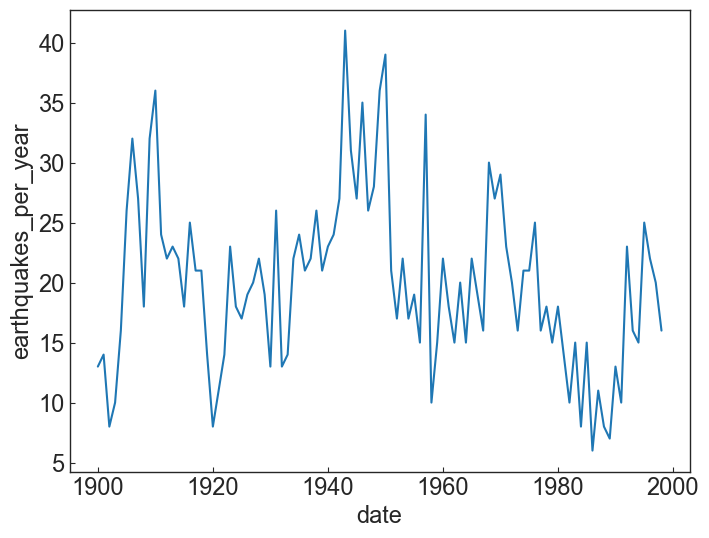

In [38]:
# Fit model
model = ARIMA(earthquake, order=(1,0,1))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print("Mean Absolute Error: {}".format(mae))

# Make plot of time series for comparison
sns.lineplot(x=earthquake.index, y=earthquake.earthquakes_per_year);

In [39]:
''' check the summary '''
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                   ARIMA(1, 0, 1)   Log Likelihood                -316.228
Date:                  Sun, 25 Sep 2022   AIC                            640.456
Time:                          03:01:50   BIC                            650.837
Sample:                      01-01-1900   HQIC                           644.656
                           - 01-01-1998                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6684      2.137      9.202      0.000      15.479      23.858
ar.L1          0.8306      0.084      9.881      0.000       0.666       0.995
ma.L1         -0.4369      0.140     -3.119      0.002      -0.711      -0.162
sigma2        34.6640      4.985      6.953      0.000      24.893      44.435
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.51
Prob(Q):                              0.93   Prob(JB):                         0.06
Heteroskedasticity (H):               0.69   Skew:                             0.56
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### `plot_diagnostics()`

| Test | Good fit |
| ---  | --- |
| Standardized residual | There are no obvious patterns in the residuals |
| Histogram plus kde estimate | The KDE curve should be very similar to the normal distribution |
| Normal Q-Q | Most of the data points should lie on the straight line |
| Correlogram | 95% of correlations for lag greater than zero should not be significant |

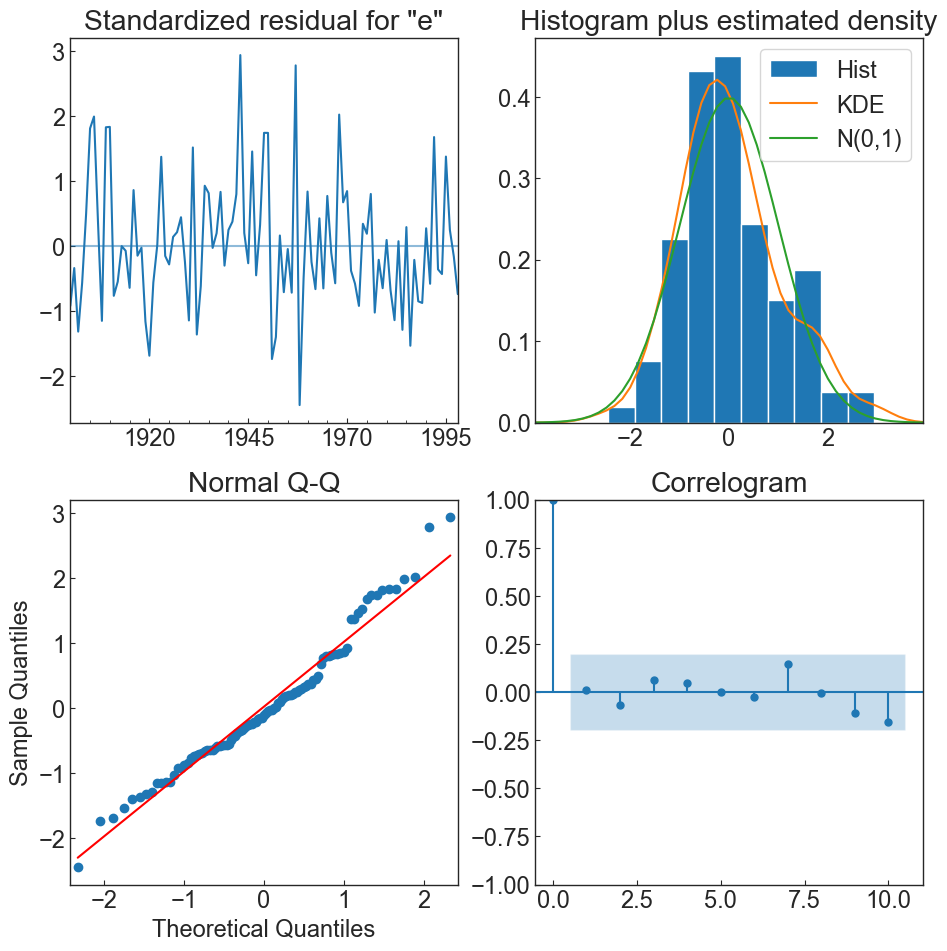

In [40]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(11,11));

## Box-Jenkins Methodology

- identification
	- Is the time series stationary?
	- What differencing will make it stationary?
	- What transforms will make it stationary?
	- What values of p and q are most promising?
	- tools:
		- plot the time series: df.plot()
		- use augmented Dicky-Fuller test: adfuller()
		- use transforms and/or differencing: df.diff(), np.log(), np.sqrt()
		- plot ACF/PACF: plot_acf(), plot_pacf()
- estimation
	- Use the data to train the model coefficients
	- Done for us using model.fit()
	- Choose between models using AIC and BIC
		- results.aic, results.bic
- model diagnostics
	- Are the residuals uncorrelated?
	- Are residuals normally distributed?
		- results.plot_diagnostics()
		- results.summary()
- Decision
- Repeat
- Production
	- Ready to make forecast
		- results.get_forecast()

ADF Statistic: -3.185899096242139
p-value: 0.02081554164411422


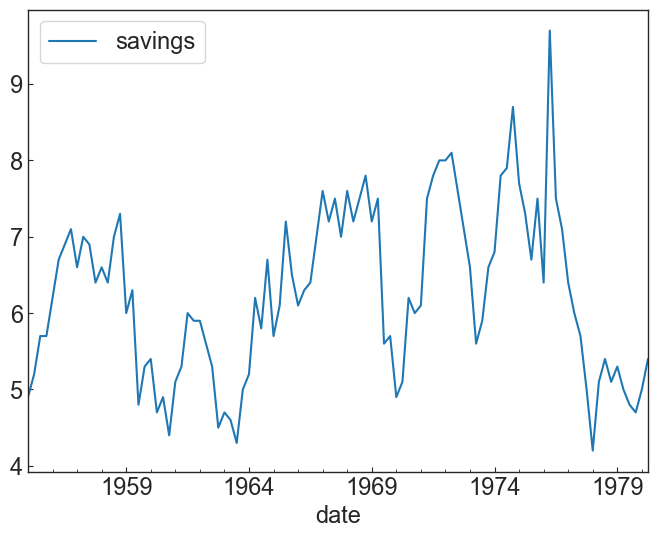

In [41]:
# Plot time series
savings.plot()

# Run Dicky-Fuller test
result = adfuller(savings['savings'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

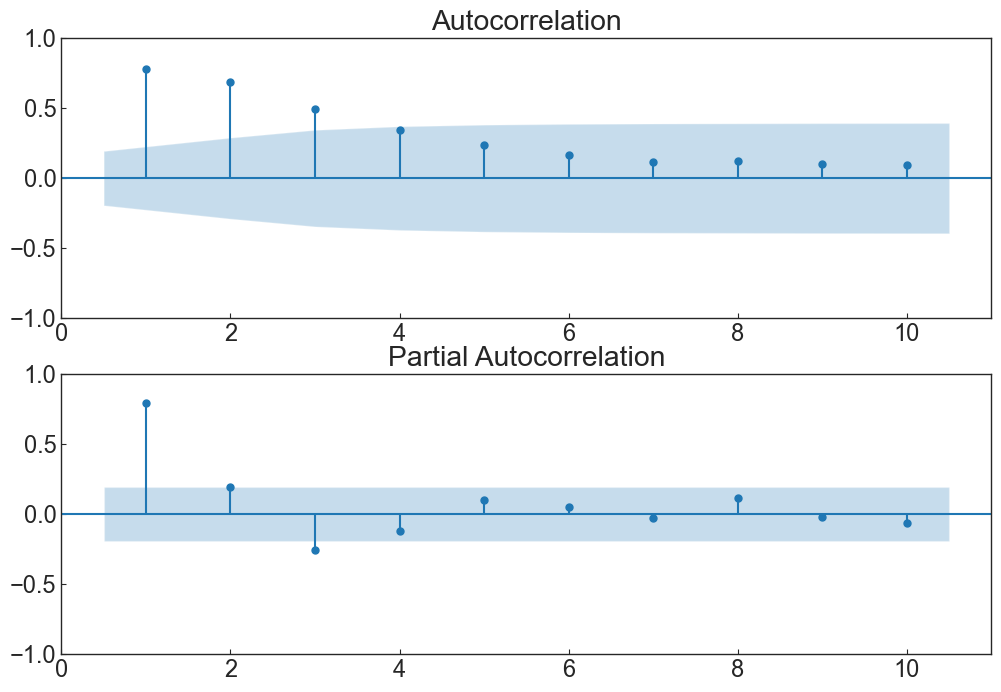

In [42]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(savings, lags=10, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(savings, lags=10, zero=False, ax=ax2);

In [43]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-3
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
        try:
            # Create and fit ARMA(p,q) model
            model = ARIMA(savings, order=(p,0,q), trend='c')
            results = model.fit()
        
            # Print p, q, AIC, BIC
            #print(p, q, results.aic, results.bic)
            order_aic_bic.append((p,q,results.aic, results.bic))

        except:
            print("no good: ", p, q, None, None)

In [44]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print("----- sort by AIC -----")
print(order_df.sort_values('AIC'))

print("----- sort by BIC -----")
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

----- sort by AIC -----
    p  q         AIC         BIC
6   1  2  207.652984  220.777848
12  3  0  209.544929  222.669793
7   1  3  209.574983  225.324820
10  2  2  209.579031  225.328868
13  3  1  210.821473  226.571310
14  3  2  211.457595  229.832405
11  2  3  211.574982  229.949792
15  3  3  213.356509  234.356291
9   2  1  213.430359  226.555223
8   2  0  213.972322  224.472213
5   1  1  215.700389  226.200280
4   1  0  216.203480  224.078398
3   0  3  217.597205  230.722069
2   0  2  232.167827  242.667718
1   0  1  267.069710  274.944628
0   0  0  313.602866  318.852811
----- sort by BIC -----
    p  q         AIC         BIC
6   1  2  207.652984  220.777848
12  3  0  209.544929  222.669793
4   1  0  216.203480  224.078398
8   2  0  213.972322  224.472213
7   1  3  209.574983  225.324820
10  2  2  209.579031  225.328868
5   1  1  215.700389  226.200280
9   2  1  213.430359  226.555223
13  3  1  210.821473  226.571310
14  3  2  211.457595  229.832405
11  2  3  211.574982  229.94

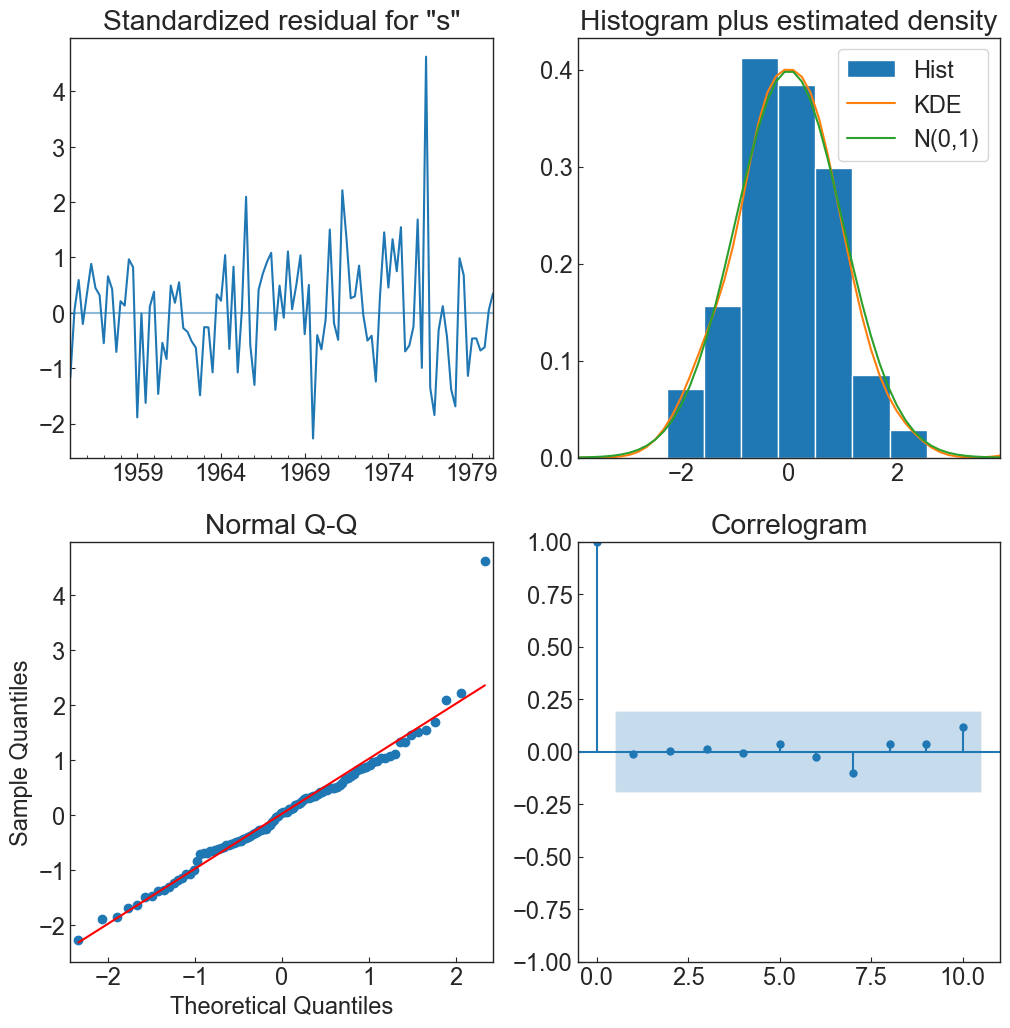

In [45]:
# Create and fit model
model = ARIMA(savings, order=(1,0,2), trend='c')
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(12,12));

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                savings   No. Observations:                  102
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -98.826
Date:                Sun, 25 Sep 2022   AIC                            207.653
Time:                        03:01:53   BIC                            220.778
Sample:                    01-01-1955   HQIC                           212.968
                         - 04-01-1980                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1949      0.323     19.169      0.000       5.561       6.828
ar.L1          0.7284      0.111      6.534      0.000       0.510       0.947
ma.L1         -0.0538      0.145     -0.370      0.711      -0.338       0.231
ma.L2          0.3681      0.097      3.814      0.000       0.179       0.557
sigma2         0.4012      0.043      9.264      0.000       0.316       0.486
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                55.12
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                             0.82
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Chap4. Seasonal ARIMA Models

- a time series as being composed of trend, seasonal and residual components.

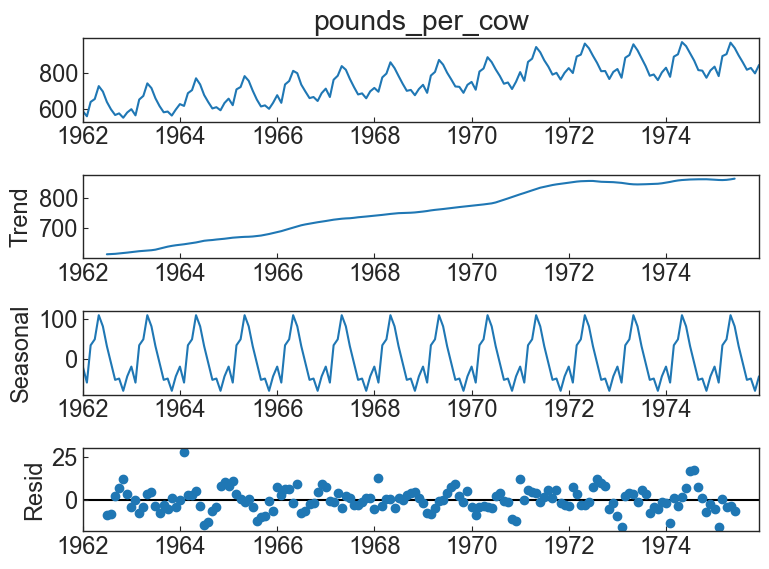

In [47]:
# Perform additive decomposition
decomp = seasonal_decompose(milk_production['pounds_per_cow'], 
                            period=12)

# Plot decomposition
decomp.plot();

Water Consumers in London

- By eye you can't see any obvious seasonal pattern, however your eyes aren't the best tools you have.

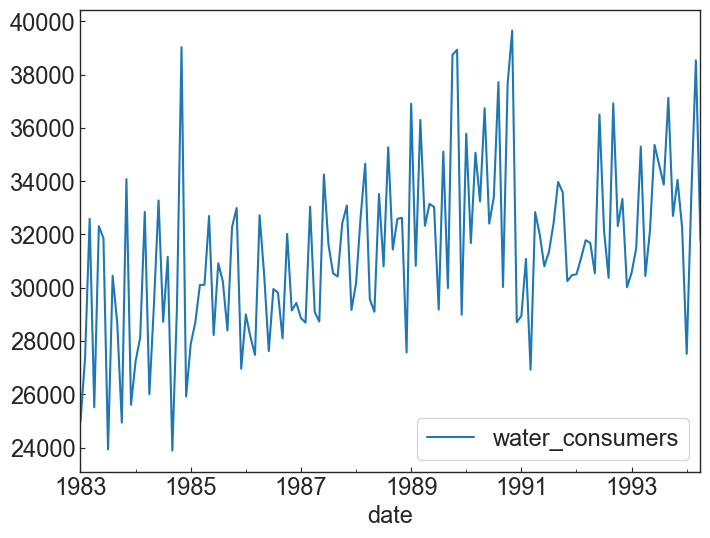

In [48]:
water.plot();

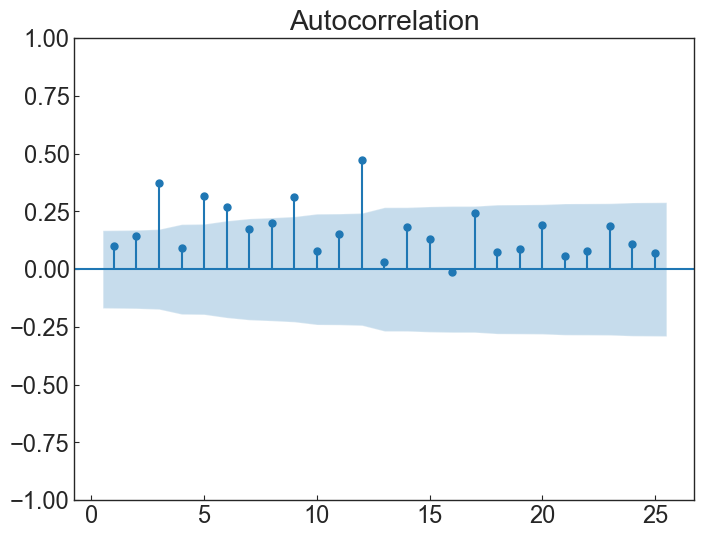

In [49]:
# Plot the ACF on ax1
plot_acf(water['water_consumers'], lags=25, zero=False);

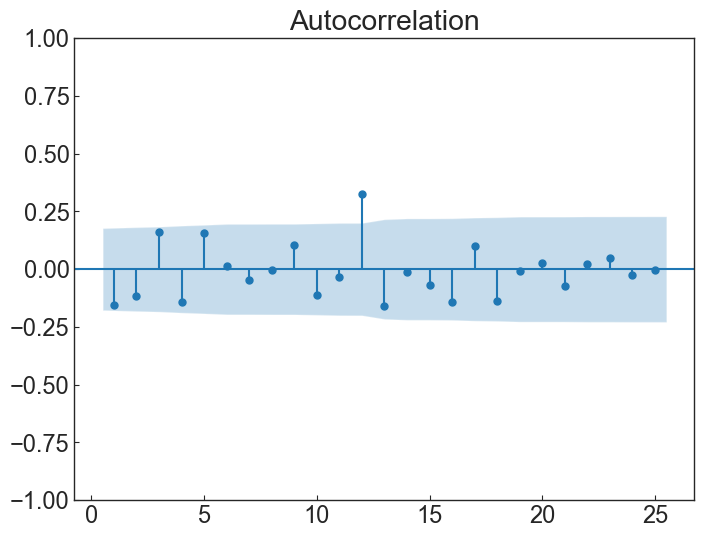

In [50]:
# Subtract the rolling mean
water_2 = water - water.rolling(15).mean()

# Drop the NaN values
water_2 = water_2.dropna()

# Plot the ACF
plot_acf(water_2['water_consumers'], lags=25, zero=False);

> 12 time steps is the time period of the seasonal component of the data

## SARIMA Models

- SARIMA(p,d,q)(P,D,Q)S
	- Non-seasonal orders
		- p: autoregressive order
		- d: differencing order
		- q: moving average order
	- Seasonal order
		- P: seasonal autoregressive order
		- D: seasonal differencing order
		- Q: seasonal moving average order
		- S: number of time steps per cycle

In [51]:
# Create a SARIMAX model
model = ARIMA(sample_sarima, order=(1,1,0), seasonal_order=(0,1,1,12))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  Y   No. Observations:                   90
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -690.735
Date:                            Sun, 25 Sep 2022   AIC                           1387.469
Time:                                    03:01:54   BIC                           1394.501
Sample:                                01-01-2013   HQIC                          1390.282
                                     - 03-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1326      0.116     -1.141      0.254      -0.361       0.095
ma.S.L12      -0.9951      0.353   

## Choosing SARIMA order

- create non-seasonal and seasonal ACF and PACF plots and use the table to choose the appropriate model orders.

| | AR(p) | MA(q) | ARMA(p,q) |
| ---  | --- | --- | --- |
| ACF  | Tails off | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p | Tails off | Tails off |

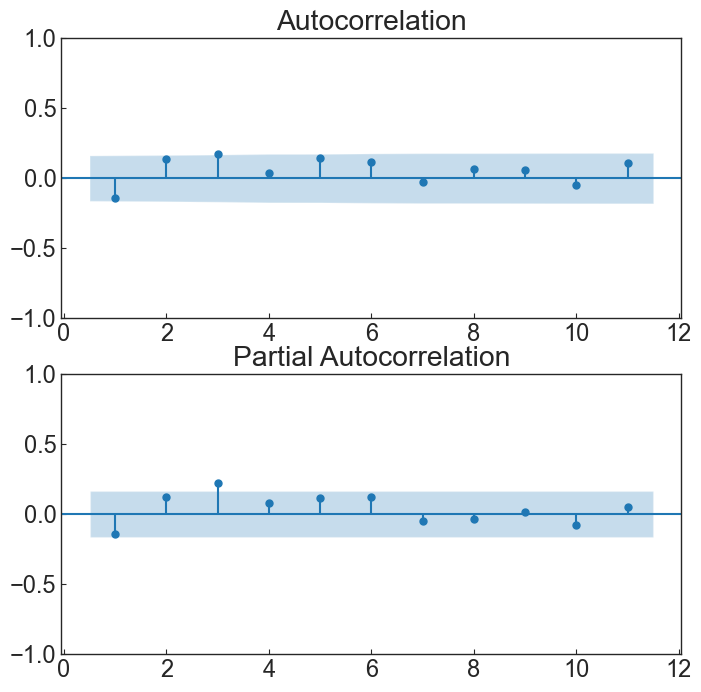

In [52]:
# Take the first and seasonal differences and drop NaNs
aus_employment_diff = aus_employment.diff().diff(12).dropna()

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))

# Plot the ACF on ax1
plot_acf(aus_employment_diff,lags=11,zero=False,ax=ax1)

# Plot the PACF on ax2
plot_pacf(aus_employment_diff,lags=11,zero=False, ax=ax2);

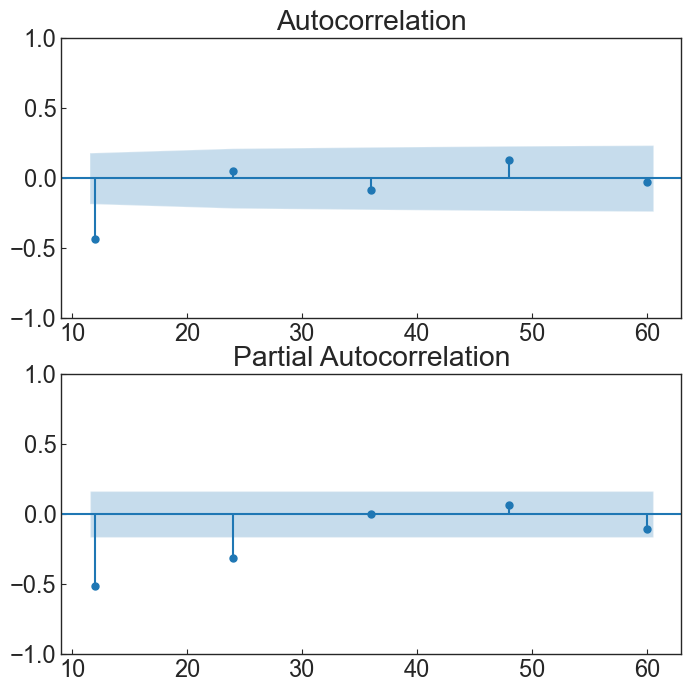

In [53]:
# Make list of lags
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))

# Plot the ACF on ax1
plot_acf(aus_employment_diff, lags=lags, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(aus_employment_diff, lags=lags, zero=False, ax=ax2);

> best model: SARIMAX(0,1,0)(0,1,1)$_{12}$

## SARIMA vs ARIMA Forecast

In [54]:
arima_results  = ARIMA(wisconsin_test, order=(3,1,2)).fit()
sarima_results = ARIMA(wisconsin_test, order=(0,1,1), seasonal_order=(1,1,1,12)).fit()

In [55]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_forecast(steps=25)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_pred = sarima_results.get_forecast(steps=25)
sarima_mean = sarima_pred.predicted_mean

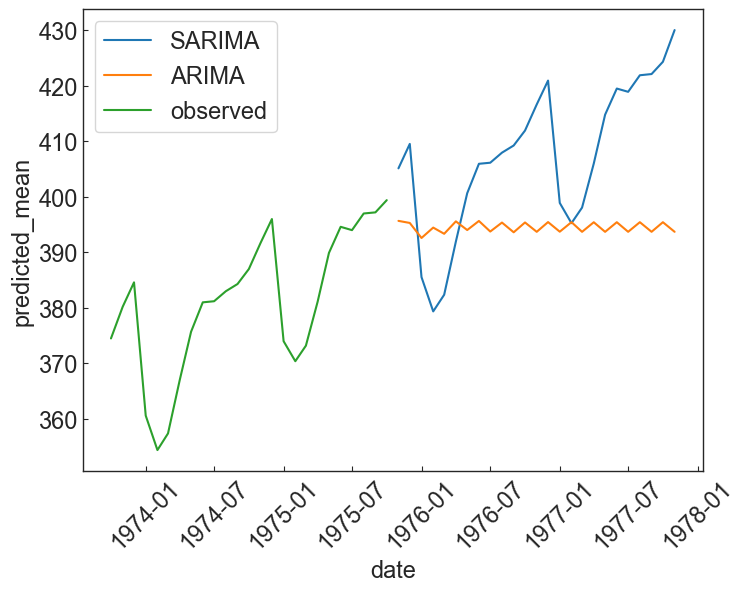

In [56]:
# Plot mean ARIMA and SARIMA predictions and observed

fig, ax = plt.subplots()
sns.lineplot(x=sarima_mean.index, y=sarima_mean, label='SARIMA', ax=ax)
sns.lineplot(x=arima_mean.index, y=arima_mean, label='ARIMA', ax=ax)
sns.lineplot(x=wisconsin_test.index, y=wisconsin_test.number_in_employment, label='observed', ax=ax)
ax.tick_params(axis='x', rotation=45);

## Automation and Saving

In [57]:
# Create auto_arima model
model1 = pm.auto_arima(sample_sarima, seasonal=True, m=7, d=0, D=1, \
                      max_p=2, max_q=2, \
                      trace=True, error_action='ignore', suppress_warnings=True) 

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1124.699, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1120.585, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1122.418, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1122.870, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1125.340, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1120.007, Time=0.19 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=1121.898, Time=0.18 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1121.058, Time=0.14 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=1119.151, Time=0.14 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=1119.433, Time=0.08 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=1120.903, Time=0.21 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=1120.149, Time=0.08 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=1120.015, Time=0.18 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : 

### Saving and Updating models

In [58]:
# Pickle it
joblib.dump(model1,os.path.join(datadir_pr,'candy_model.pkl'))

['../datasets/processed/candy_model.pkl']

In [59]:
# Load the model back in
loaded_model = joblib.load(os.path.join(datadir_pr,'candy_model.pkl'))

In [60]:
# Update the model
#loaded_model.update(df_new) # w/ new dataframe (extended)